In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the aggregated data
X = pd.read_csv('input_data/processed/aggregated_data_001.csv')
print(X.shape)

(1308050, 36)


In [3]:
cols = ['LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'OBLAST_ID',
       'GRID_CELL', 'DAY_OF_YEAR', 'FIRE_COUNT_CELL',
       'GRID_CELL_NEIGHBOR_100km', 'FIRE_COUNT_CELL_NEIGHBOR_100km',
       'GRID_CELL_NEIGHBOR_10km', 'FIRE_COUNT_CELL_NEIGHBOR_10km',
       'FIRE_COUNT_OBLAST', 'FIRE_COUNT_CELL_AVG_7D',
       'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_7D',
       'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_7D', 'FIRE_COUNT_OBLAST_AVG_7D',
       'FIRE_COUNT_CELL_AVG_30D', 'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_30D',
       'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_30D', 'FIRE_COUNT_OBLAST_AVG_30D',
       'POP_DENSITY_CELL_AVG', 'POP_DENSITY_CELL_NEIGHBOR_100km_AVG',
       'POP_DENSITY_CELL_NEIGHBOR_10km_AVG', 'LAND_USE_CLASS_1',
       'LAND_USE_CLASS_2', 'LAND_USE_CLASS_3', 'LAND_USE_CLASS_4',
       'LAND_USE_CLASS_1_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_2_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_3_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_4_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_1_NEIGHBOR_10km_AVG',
       'LAND_USE_CLASS_2_NEIGHBOR_10km_AVG',
       'LAND_USE_CLASS_3_NEIGHBOR_10km_AVG',
       'LAND_USE_CLASS_4_NEIGHBOR_10km_AVG']

In [4]:
# Lets drop the columns that are not needed
columns_to_drop = [
       'ACQ_TIME', 'OBLAST_ID',
       'GRID_CELL', 'GRID_CELL_NEIGHBOR_100km',
       'GRID_CELL_NEIGHBOR_10km',
       'FIRE_COUNT_OBLAST',
       'FIRE_COUNT_OBLAST_AVG_7D',
       'FIRE_COUNT_CELL_AVG_30D', 'FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_30D',
       'FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_30D', 'FIRE_COUNT_OBLAST_AVG_30D',
       'POP_DENSITY_CELL_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_1_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_2_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_3_NEIGHBOR_100km_AVG',
       'LAND_USE_CLASS_4_NEIGHBOR_100km_AVG',]
X = X.drop(columns=columns_to_drop)
X.shape

(1308050, 20)

In [5]:
# We want to use plot the data later, thus we need to copy the original values of the temporal and spatial features
temporal_spatial_features = ['DAY_OF_YEAR', 'LATITUDE', 'LONGITUDE']
X_ts = X[temporal_spatial_features].copy()

In [6]:
# Get the data for those rows with ACQ_DATE smaller than 2022-02-24 (the first day of the UKR war)
# and for those rows with ACQ_DATE greater than 2022-02-24

# Data before the war
X_pre = X[X['ACQ_DATE'] < '2022-02-24']
X_ts_pre = X_ts[X['ACQ_DATE'] < '2022-02-24']
X_pre.drop(columns=['ACQ_DATE'], inplace=True)

# Data after the war
X_post = X[X['ACQ_DATE'] >= '2022-02-24']
X_ts_post = X_ts[X['ACQ_DATE'] >= '2022-02-24']
X_post.drop(columns=['ACQ_DATE'], inplace=True)

X_pre.shape, X_post.shape

((896367, 19), (411683, 19))

In [7]:
# Lets transform the data so that we can use it for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_pre)
X_pre_scaled = scaler.transform(X_pre)

X_pre_scaled = pd.DataFrame(X_pre_scaled, columns=X_pre.columns)
X_pre_scaled.head()

,LATITUDE,LONGITUDE,DAY_OF_YEAR,FIRE_COUNT_CELL,FIRE_COUNT_CELL_NEIGHBOR_100km,FIRE_COUNT_CELL_NEIGHBOR_10km,FIRE_COUNT_CELL_AVG_7D,FIRE_COUNT_CELL_NEIGHBOR_100km_AVG_7D,FIRE_COUNT_CELL_NEIGHBOR_10km_AVG_7D,POP_DENSITY_CELL_AVG,POP_DENSITY_CELL_NEIGHBOR_10km_AVG,LAND_USE_CLASS_1,LAND_USE_CLASS_2,LAND_USE_CLASS_3,LAND_USE_CLASS_4,LAND_USE_CLASS_1_NEIGHBOR_10km_AVG,LAND_USE_CLASS_2_NEIGHBOR_10km_AVG,LAND_USE_CLASS_3_NEIGHBOR_10km_AVG,LAND_USE_CLASS_4_NEIGHBOR_10km_AVG
0,-1.087270,1.168188,-2.434418,0.516762,-0.602185,-0.368227,-0.161225,-0.575252,-0.198817,1.338005,-0.517793,-0.286956,-0.345282,0.658513,-0.363323,-0.580791,-0.675893,-1.191845,-0.535165
1,-1.087270,1.168188,-2.434418,0.516762,-0.602185,-0.368227,-0.068254,-0.579963,-0.228057,1.338005,-0.517793,-0.286956,-0.345282,0.658513,-0.363323,-0.580791,-0.675893,-1.191845,-0.535165
2,-1.087270,1.168188,-2.434418,0.516762,-0.602185,-0.368227,0.024716,-0.584675,-0.257296,1.338005,-0.517793,-0.286956,-0.345282,0.658513,-0.363323,-0.580791,-0.675893,-1.191845,-0.535165
3,-1.048173,1.149366,-2.434418,-0.673332,-0.602185,-0.502507,-0.719045,-0.589386,-0.432732,0.670295,-0.216626,-0.286956,-0.345282,0.658513,-0.363323,-0.580791,-0.675893,-1.191845,-0.535165
4,1.141215,-0.918662,-2.421335,-0.673332,-0.635089,-0.502507,-0.719045,-0.631001,-0.510704,-0.374737,-0.665485,-0.286956,-0.345282,0.658513,-0.363323,0.089060,0.064172,0.622077,-0.110112


In [8]:
# Now lets apply PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_pre_pca = pca.fit_transform(X_pre_scaled)

X_pre_pca = pd.DataFrame(X_pre_pca)
# X_pre_pca = pd.DataFrame(X_pre_scaled)
X_pre_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.041202,0.526002,-0.685900,0.245576,-0.831545,-1.305168,-1.116384,-0.515886,-0.629098,2.509760,-0.797292,-0.367471,1.118544,0.060079,-0.447468
1,-1.025938,0.528169,-0.702935,0.203860,-0.850552,-1.302336,-1.115193,-0.555967,-0.607147,2.519812,-0.800275,-0.362471,1.116270,0.061848,-0.446161
2,-1.010675,0.530336,-0.719970,0.162144,-0.869558,-1.299504,-1.114002,-0.596049,-0.585196,2.529864,-0.803257,-0.357470,1.113996,0.063616,-0.444854
3,-1.738315,0.311729,-0.047101,0.913669,-0.484764,-1.338019,-0.821209,-0.111830,-0.792112,2.353296,-0.741462,-0.230789,0.817508,-0.300224,-0.183696
4,-1.162470,-0.986031,1.644651,0.405417,-0.779994,-1.149192,-1.247919,-0.859037,-1.398671,0.084279,0.387697,0.476099,-0.094345,0.534728,-0.051346


In [9]:
# Select a set of random samples both from X_ts and X_pca, the indices must be the same
np.random.seed(42)
n_samples = 500000
sample_indices = np.random.choice(X_ts_pre.index, n_samples, replace=False)
X_ts_pre_sample = X_ts_pre.loc[sample_indices]
X_pre_pca_sample = X_pre_pca.loc[sample_indices]

In [16]:
# Use a clustering algorithm where I can specify the number of clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15)
kmeans.fit(X_pre_pca_sample)

# Get the labels of the clusters
y_labels = kmeans.labels_

# Get the size of each cluster
cluster_sizes = pd.Series(kmeans.labels_).value_counts()
cluster_sizes

1     95396
6     66758
14    46332
5     44724
10    44122
7     41169
3     35054
9     30698
0     22984
13    21857
8     17757
12    15398
11     7561
2      7404
4      2786
Name: count, dtype: int64

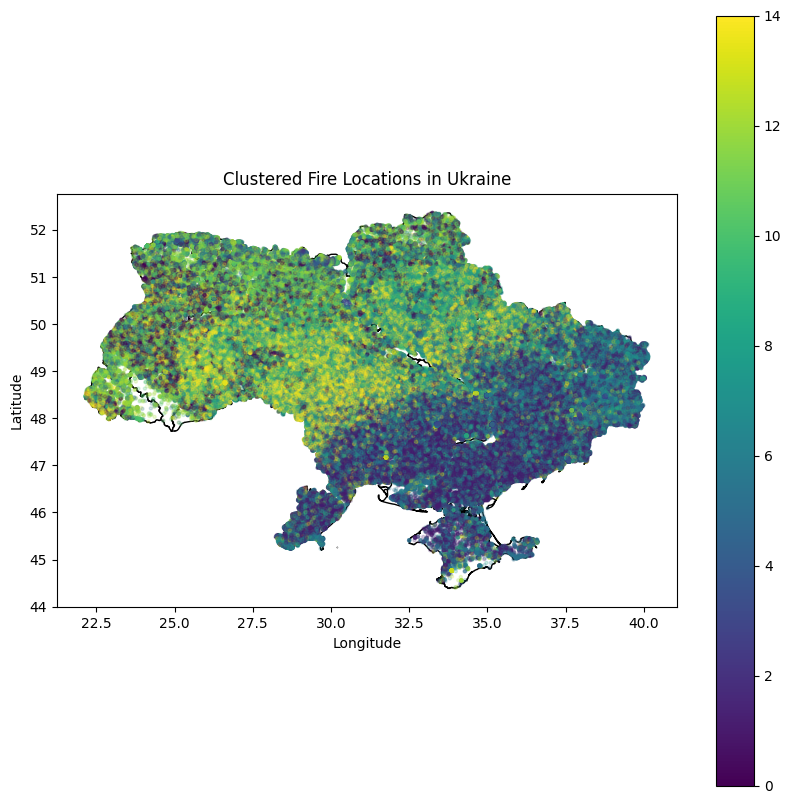

In [33]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
aggregated_data_sample_gdf = gpd.GeoDataFrame(X_ts_pre_sample, geometry=gpd.points_from_xy(X_ts_pre_sample.LONGITUDE, X_ts_pre_sample.LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
aggregated_data_sample_gdf.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Add cluster labels to the GeoDataFrame
aggregated_data_sample_gdf['cluster'] = y_labels

# Select only samples with certain cluster labels
# aggregated_data_sample_gdf = aggregated_data_sample_gdf[aggregated_data_sample_gdf['cluster'].isin([0])]

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
aggregated_data_sample_gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=5, alpha=0.2, legend=True)
plt.title('Clustered Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [18]:
# Lets train a model to predict the cluster labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# Split the data into training and testing sets
X_pre_train, X_pre_test, y_pre_train, y_pre_test = train_test_split(X_pre_pca_sample, y_labels, test_size=0.2)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_pre_train, y_pre_train)

# Predict the cluster labels
y_pre_proba = rf.predict_proba(X_pre_test)

# Get the predicted cluster labels from the probabilities
y_pre_pred = np.argmax(y_pre_proba, axis=1)

# Calculate the balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_pre_test, y_pre_pred)
balanced_accuracy

np.float64(0.9785305816844344)

In [19]:
# Apply the scaler and PCA to X_post data
X_post_scaled = scaler.transform(X_post)
X_post_scaled = pd.DataFrame(X_post_scaled, columns=X_post.columns)
X_post_pca = pca.transform(X_post_scaled)
X_post_pca = pd.DataFrame(X_post_pca)
# X_post_pca = pd.DataFrame(X_post_scaled)

X_post_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.354577,1.540931,1.705412,-2.552612,2.692922,-1.884112,0.207465,-1.444416,-0.290197,1.922363,-1.924178,2.304869,-0.218028,-0.164315,-0.837571
1,0.990296,1.131747,2.874835,-0.271466,2.863638,-1.613825,0.228763,-0.469292,-0.546513,1.168303,-1.688240,0.707059,0.548195,-0.622638,-0.284028
2,2.176608,1.551501,2.755401,-0.780074,3.513786,-1.949677,0.043447,-0.100502,-0.704773,1.574698,-1.815780,2.138002,-0.081601,-0.068468,-1.026751
3,2.659630,1.503882,2.355487,-1.383900,3.259624,-1.906849,0.004974,-0.562144,-0.518295,1.689344,-1.853110,2.193716,-0.117912,-0.080793,-0.990415
4,3.584749,1.473474,1.553402,-2.546828,2.680947,-1.861825,0.208692,-1.516068,-0.259478,1.927084,-1.935156,2.305351,-0.222037,-0.161924,-0.834682


In [20]:
# Predict the cluster labels for the X_post data
y_post_proba = rf.predict_proba(X_post_pca)
y_post_pred = np.argmax(y_post_proba, axis=1)

In [41]:
from scipy.stats import entropy

# Calculate the entropy of the predicted probabilities for pre and post war data
entropy_pre = entropy(y_pre_proba, axis=1)
entropy_post = entropy(y_post_proba, axis=1)

# Set a threshold for out-of-distribution detection based on the pre-war data entropy
threshold_entropy = np.percentile(entropy_pre, 98)  # 95th percentile

# Detect out-of-distribution points in the post-war data
ood = pd.Series(entropy_post > threshold_entropy)

# Adjust the indices to fit with the original data
ood.index = X_post.index

# List the indices of out-of-distribution points
ood_indices = list(ood[ood].index)

# Print the results
print(f"Number of out-of-distribution points based on entropy: {ood.sum()}")
print(f"Indices of out-of-distribution points based on entropy: {ood_indices}")
print(f"Relative amount of out-of-distribution points based on entropy: {ood.mean()}")

Number of out-of-distribution points based on entropy: 42436
Indices of out-of-distribution points based on entropy: [896399, 896409, 896412, 896524, 896560, 896591, 896632, 896761, 896775, 896776, 896810, 896826, 896899, 896900, 897018, 897023, 897034, 897041, 897048, 897054, 897069, 897072, 897081, 897083, 897087, 897088, 897090, 897123, 897125, 897126, 897128, 897129, 897132, 897135, 897138, 897139, 897177, 897178, 897184, 897200, 897202, 897207, 897210, 897213, 897214, 897216, 897217, 897222, 897227, 897228, 897233, 897249, 897250, 897252, 897293, 897310, 897328, 897329, 897330, 897331, 897338, 897343, 897350, 897357, 897358, 897401, 897424, 897425, 897443, 897479, 897483, 897504, 897512, 897527, 897531, 897572, 897577, 897592, 897596, 897597, 897598, 897628, 897635, 897652, 897665, 897671, 897679, 897691, 897707, 897708, 897709, 897710, 897712, 897715, 897730, 897731, 897740, 897746, 897759, 897767, 897778, 897780, 897787, 897788, 897801, 897804, 897818, 897820, 897829, 897834, 89

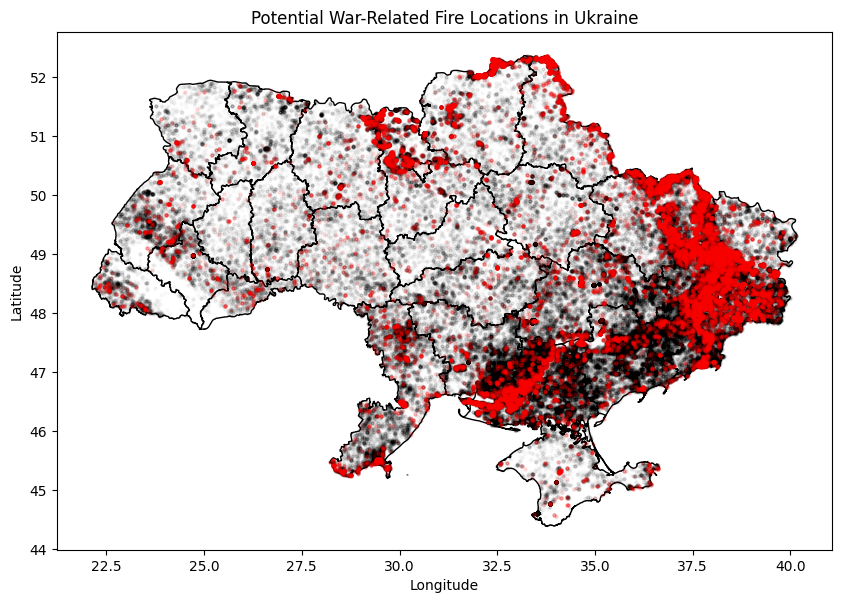

In [43]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile containing the administrative borders of Ukraine
ukraine_borders = gpd.read_file('input_data/raw/ukr_borders/ua.shp')

# Ensure the aggregated_data_sample is a GeoDataFrame
# Select only the out-of-distribution samples
ood_df = gpd.GeoDataFrame(X_ts_post.loc[ood_indices], geometry=gpd.points_from_xy(X_ts_post.loc[ood_indices].LONGITUDE, X_ts_post.loc[ood_indices].LATITUDE))
# Select only the non out-of-distribution samples
n_ood_df = gpd.GeoDataFrame(X_ts_post.loc[~ood], geometry=gpd.points_from_xy(X_ts_post.loc[~ood].LONGITUDE, X_ts_post.loc[~ood].LATITUDE))

# Set the same coordinate reference system (CRS) for both GeoDataFrames
ood_df.set_crs(epsg=4326, inplace=True)
n_ood_df.set_crs(epsg=4326, inplace=True)
ukraine_borders.set_crs(epsg=4326, inplace=True)

# Plot the Ukraine map and the clustered samples
fig, ax = plt.subplots(figsize=(10, 10))
ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
# Plot the non out-of-distribution samples in black with high transparency
n_ood_df.plot(ax=ax, color='black', markersize=5, alpha=0.02)
# Plot the out-of-distribution samples in red with high transparency
ood_df.plot(ax=ax, color='red', markersize=5, alpha=0.1)
plt.title('Potential War-Related Fire Locations in Ukraine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()